In [1]:
library(Ragas)
library(ggplot2)
library(cowplot)

Loading required package: Seurat

Attaching SeuratObject

Registered S3 methods overwritten by 'treeio':
  method              from    
  MRCA.phylo          tidytree
  MRCA.treedata       tidytree
  Nnode.treedata      tidytree
  Ntip.treedata       tidytree
  ancestor.phylo      tidytree
  ancestor.treedata   tidytree
  child.phylo         tidytree
  child.treedata      tidytree
  full_join.phylo     tidytree
  full_join.treedata  tidytree
  groupClade.phylo    tidytree
  groupClade.treedata tidytree
  groupOTU.phylo      tidytree
  groupOTU.treedata   tidytree
  is.rooted.treedata  tidytree
  nodeid.phylo        tidytree
  nodeid.treedata     tidytree
  nodelab.phylo       tidytree
  nodelab.treedata    tidytree
  offspring.phylo     tidytree
  offspring.treedata  tidytree
  parent.phylo        tidytree
  parent.treedata     tidytree
  root.treedata       tidytree
  rootnode.phylo      tidytree
  sibling.phylo       tidytree

Registered S3 methods overwritten by 'car':
  method     

In [2]:
load('colors.RData')

## Load Seurat objects

In [3]:
cd4.harmony.clean <- readRDS('sorted.cd4.total.rds')
cd4.harmony.clean
cd4.isgh.clean <- readRDS('sorted.cd4.isgh.rds')
cd4.isgh.clean

An object of class Seurat 
26053 features across 239473 samples within 1 assay 
Active assay: RNA (26053 features, 2000 variable features)
 3 dimensional reductions calculated: pca, harmony, umap

An object of class Seurat 
26053 features across 11828 samples within 1 assay 
Active assay: RNA (26053 features, 2000 variable features)
 3 dimensional reductions calculated: pca, harmony, umap

In [4]:
names(cd4.isgh.clean[[]])

[1] "orig.ident"                  "nCount_RNA"                 
 [3] "nFeature_RNA"                "Cohort"                     
 [5] "Gender"                      "Age"                        
 [7] "Ethnicity_Race"              "Nephritis_Class"            
 [9] "Batch"                       "Group"                      
[11] "Activation"                  "Subject_ID"                 
[13] "Sample_ID"                   "SLEDAI"                     
[15] "MDG"                         "percent.mt"                 
[17] "doublet_score"               "theshold"                   
[19] "predicted_doublet"           "predicted.celltype.l3"      
[21] "predicted.celltype.l3.score" "mapping.score"              
[23] "Dataset"                     "Group_LN"                   
[25] "SLEDAI.num"                  "Group_SLEDAI"               
[27] "percent.mt.cat"              "RNA_snn_res.0.5"            
[29] "seurat_clusters"             "RNA_snn_res.0.3"

In [5]:
cd4.harmony.clean$subclusters <- "others"
idx <- match(colnames(cd4.isgh.clean), colnames(cd4.harmony.clean))
cd4.harmony.clean$subclusters[idx] <- paste('ISGH-SC',as.character(cd4.isgh.clean$seurat_clusters),sep='')

In [6]:
cd4.isg.pi <- CreatePostIntegrationObject(object = cd4.isgh.clean, parent.object = cd4.harmony.clean)

Post-integration object created



In [7]:
cd4.isg.pi <- RunFindAllMarkers(object = cd4.isg.pi, idents = "seurat_clusters", future.workers = 4)

Running multiple workers...

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3



In [8]:
cd4.isg.pi  <- RunPseudobulkAnalysis(object = cd4.isg.pi,
                                     ident.var = "seurat_clusters",
                                     group.var = "Group",
                                     sample.var = "Sample_ID",
                                     blocking.var = "Dataset",
                                     group.1 = "SLE",
                                     group.2 = "HD",
                                     auto.make.names = TRUE)

Checking validity of names...

Contrast created: group_idSLE-group_idHD

Creating single cell experiment object...

Aggregating count data...

Running differential state analysis...



0..1..2..3..


Formatting output...

Pseudobulk-analysis completed!



In [9]:
cd4.isg.pi <- CalculateExpFreqs(cd4.isg.pi,ident = "seurat_clusters")

Calculating expression frequencies for seurat_clusters: 0

Calculating expression frequencies for seurat_clusters: 1

Calculating expression frequencies for seurat_clusters: 2

Calculating expression frequencies for seurat_clusters: 3

Done!



In [10]:
cd4.isg.pi

An object of class Pi 
6 fields in the object: seurat.obj, exp.freq, markers, ds, cell.prop, parent.meta.data.
The following fields have been processed:
	seurat.obj: A Seurat object of 26053 features and 11828 cells.
		1 assay: RNA, and 3 reductions: pca, harmony, umap
	exp.freq: A list of numeric matrices containing per gene expression frequencies
		1 analysis run: 
		  ExpFreq|seurat_clusters|cutoff=0
	markers: A list of data frames containing marker results.
		1 analysis run: 
		  Markers|seurat_clusters|AllMarkers|test.use=wilcox
	ds: A list of lists and data frames containing pseudobulk analysis results.
		1 analysis run: 
		  DS|seurat_clusters|edgeR|group=Group;sample=Sample_ID;gp1=SLE;gp2=HD;contrast=SLE-HD;block=Dataset
	parent.meta.data: A list of data frames containing parent metadata
		1 metadata: 
		  ParentMetaData|parent=cd4.harmony.clean
Metadata from the parent object provided? Yes 
Subclusters integrated? No

## Figure 4a

In [11]:
isg.list <- read.csv('IFN.IRG.fromNatImm_paper.csv')

In [12]:
my.isg <- split(isg.list$features, isg.list$group)
my.isg.list <- unlist(my.isg)
names(my.isg.list) <- NULL

In [13]:
isg.exp <- GetAssayData(cd4.harmony.clean, assay = "RNA", slot = "data")[my.isg.list,]

In [14]:
if(!is.factor(cd4.harmony.clean$Subject_ID)){cd4.harmony.clean$Subject_ID <- factor(cd4.harmony.clean$Subject_ID)}

In [15]:
patient.id <- levels(cd4.harmony.clean$Subject_ID)

In [16]:
isg.exp.mat <- matrix(0, length(my.isg.list), length(patient.id))
for(i in 1:length(my.isg.list)){
    for(j in 1:length(patient.id)){
        isg.exp.mat[i,j] <- mean(isg.exp[i, which(cd4.harmony.clean$Subject_ID == patient.id[j])])
    }
}
colnames(isg.exp.mat) <- patient.id
rownames(isg.exp.mat) <- my.isg.list

In [17]:
avg.isg.exp <- colMeans(isg.exp.mat)

In [18]:
ncells.tbl <- table(cd4.harmony.clean$Subject_ID, cd4.harmony.clean$subclusters)
pcells.tbl <- ncells.tbl / rowSums(ncells.tbl)

In [19]:
pcells.df <- as.data.frame(unclass(pcells.tbl))

In [20]:
my.match <- match(rownames(pcells.df), cd4.harmony.clean$Subject_ID)
metadata.df <- cbind(pcells.df,
                   patient = cd4.harmony.clean$Subject_ID[my.match],
                   sample = cd4.harmony.clean$Sample_ID[my.match],
                   SLEDAI = cd4.harmony.clean$SLEDAI[my.match],
                   SLEDAI.num = cd4.harmony.clean$SLEDAI.num[my.match],
                   Group = cd4.harmony.clean$Group[my.match],
                   Group_SLEDAI = cd4.harmony.clean$Group_SLEDAI[my.match],
                   Group_LN = cd4.harmony.clean$Group_LN[my.match],
                   Avg.ISG.exp = avg.isg.exp
                        )
metadata.df$ISGH <- metadata.df[["ISGH-SC0"]] + metadata.df[["ISGH-SC1"]] + metadata.df[["ISGH-SC2"]] + metadata.df[["ISGH-SC3"]]
metadata.df$SLEDAI.num[is.na(metadata.df$SLEDAI.num)] <- 0

`geom_smooth()` using formula 'y ~ x'



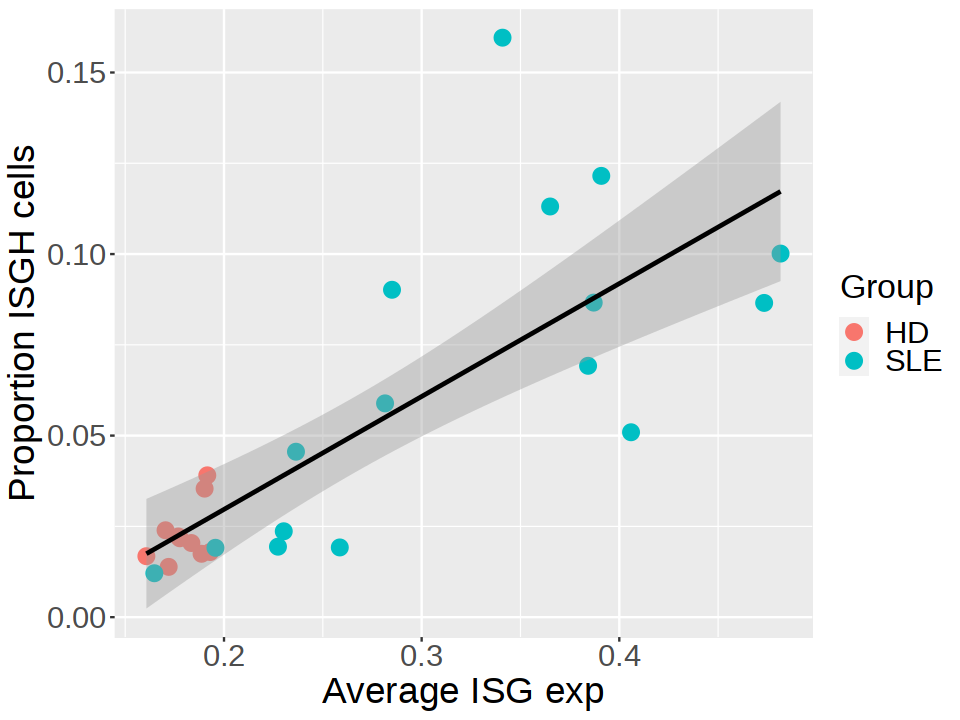

In [21]:
options(repr.plot.width = 8, repr.plot.height = 6)
p1 <- ggplot(metadata.df, aes(x=Avg.ISG.exp, y=ISGH)) + 
      geom_point( aes(color = Group), size = 4)+
      geom_smooth(method=lm, color = "black") + 
      theme(axis.text = element_text(size = 18), axis.title = element_text(size = 22),
            legend.title = element_text(size = 20), legend.text = element_text(size = 18)) + 
      labs(x = 'Average ISG exp', y = 'Proportion ISGH cells')
p1

## Figure 4b

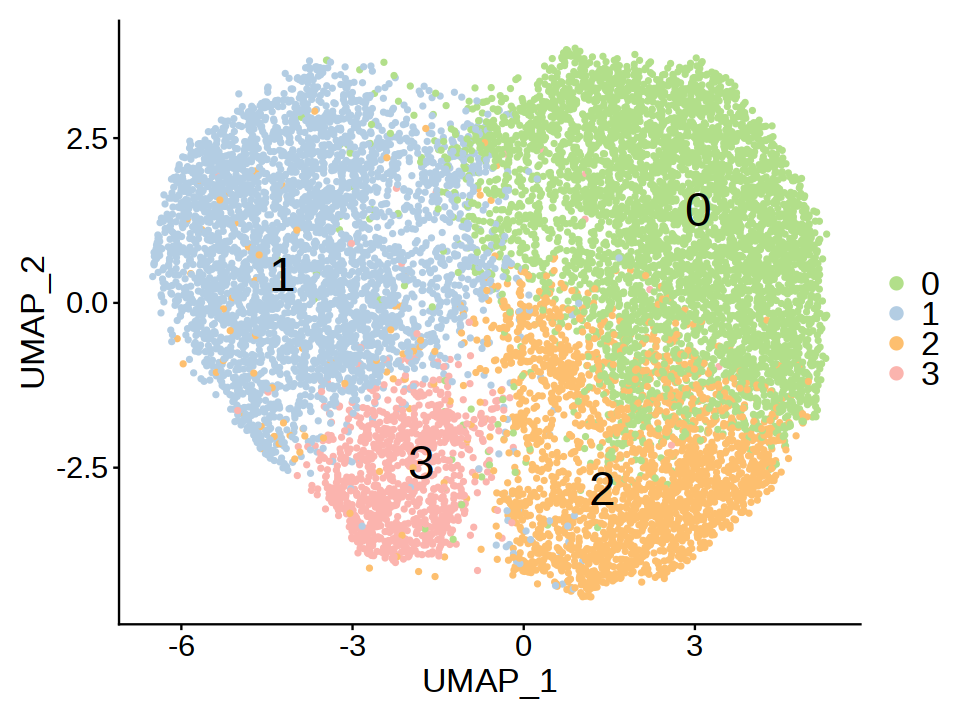

In [22]:
options(repr.plot.width = 8, repr.plot.height = 6)
p1 <- RunDimPlot(cd4.isgh.clean, label = TRUE, group.by = 'seurat_clusters', pt.size = 1,label.size =10, cols = cols.isg.clus) + 
      theme(plot.title = element_blank(), legend.text = element_text(size = 20), axis.text = element_text(size = 18), axis.title = element_text(size = 20))
p1

## Figure 4c

Centering and scaling data matrix



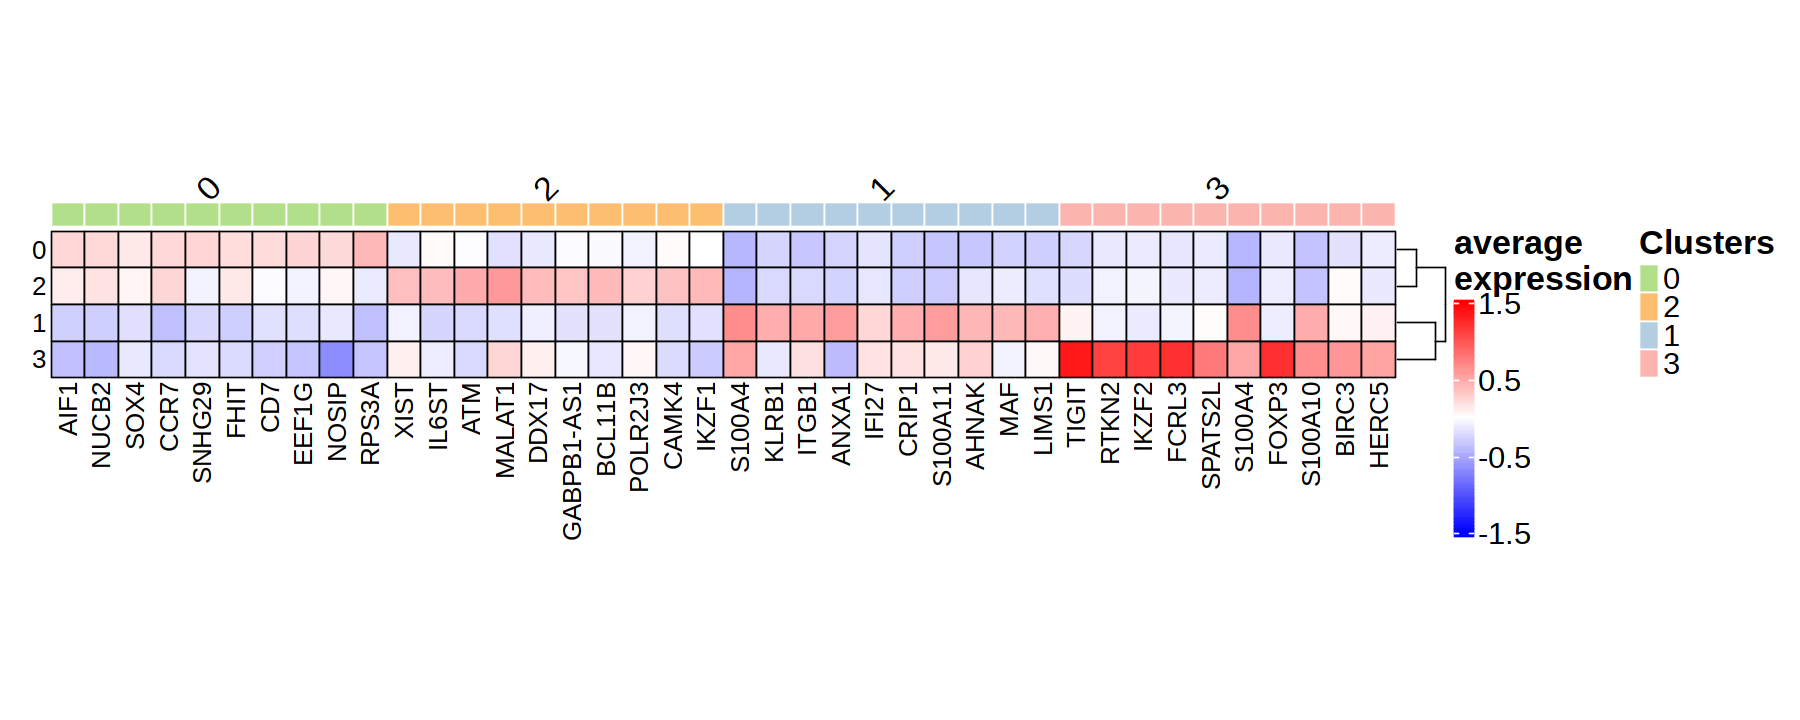

In [23]:
options(repr.plot.width = 15, repr.plot.height = 6)
p1 <- RunMatrixPlot(cd4.isg.pi, markers.key = "Markers|seurat_clusters|AllMarkers|test.use=wilcox", top.n = 10, 
                    column.fontsize =15, 
                    row.fontsize = 15,
                    column.anno.cols = cols.isg.clus,
                    column.anno.name.fontsize = 20,
                    column.anno.name.rot = 45,
                    heatmap.cols = NULL,
                    legend.label.fontsize = 18,
                    legend.title.fontsize = 20,
                    heatmap.width = 30, heatmap.height = 8)
p1

## Figure 4d

In [24]:
markers <- list(Markers = c("NKG7", "GNLY", "GZMA", "GZMK","CX3CR1", "PDCD1", "GATA3", "PTGDR2", "RORC", "CTSH", "IL17A", "CXCR5",
                                                 "FOXP3", "IKZF2", "IL2RA", "TIGIT", "CTLA4",
                                                 "CCR7", "SELL", "LEF1",
                                                 "S100A4", "KLRB1", "ANXA1"))

In [25]:
cols.column.anno <- list("Cluster" = cols.isg.clus)

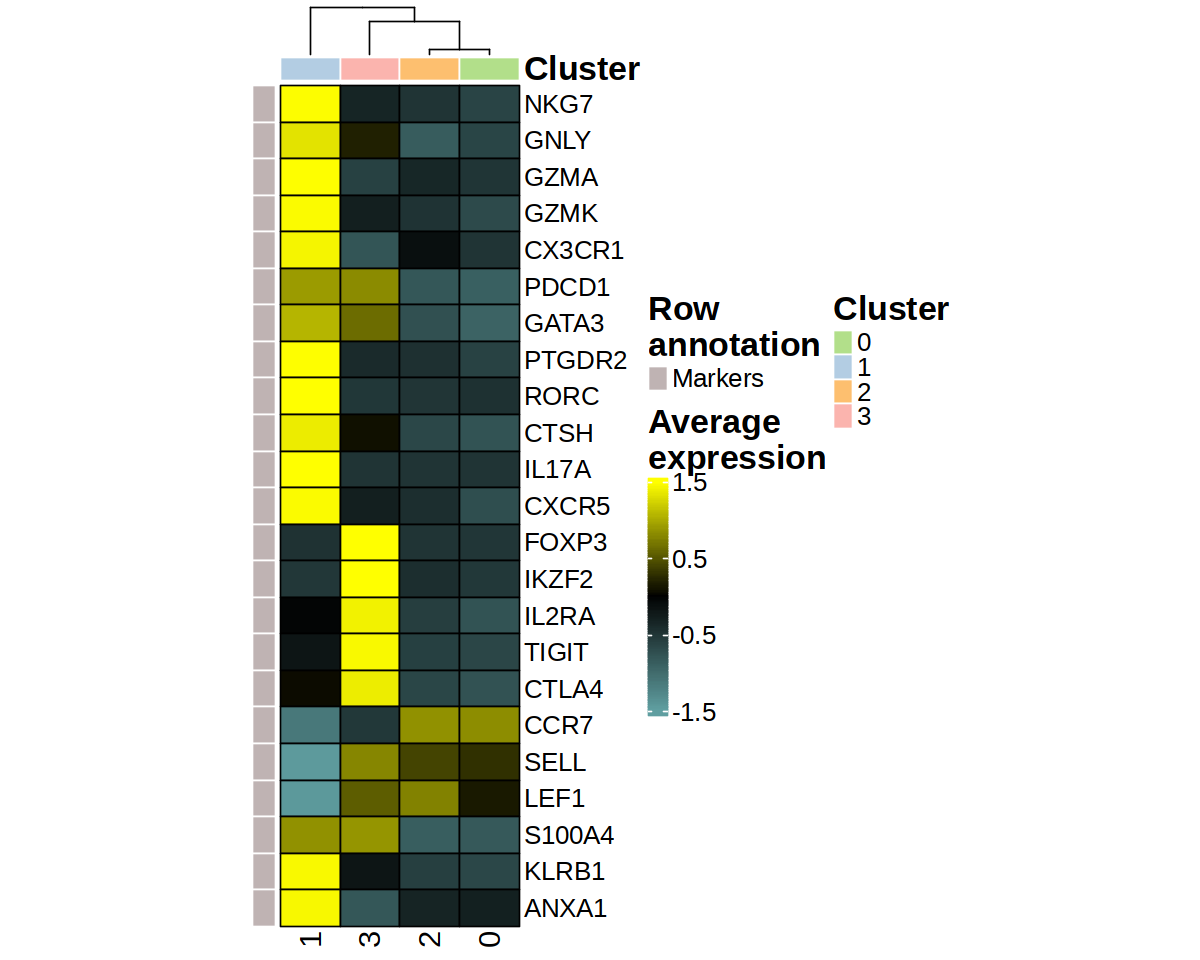

In [26]:
p1 <- RunSummarizedHeatmap(object = cd4.isg.pi, 
                           max.exp = 1.5, min.exp = (-1.5),
                           ident = "seurat_clusters", 
                           features = markers, 
                           column.annotation.cols = cols.column.anno,
                           row.annotation.cols = NULL,
                           heatmap.width = 8, heatmap.height = 20, 
                           clust.column = TRUE, 
                           clust.row = FALSE,
                           row.fontsize = 15,
                           column.fontsize = 18,
                           legend.label.fontsize = 15,
                           legend.title.fontsize = 20,
                           annotation.name.fontsize = 20)

options(repr.plot.width = 10, repr.plot.height = 8)
p1

## Figure 4e

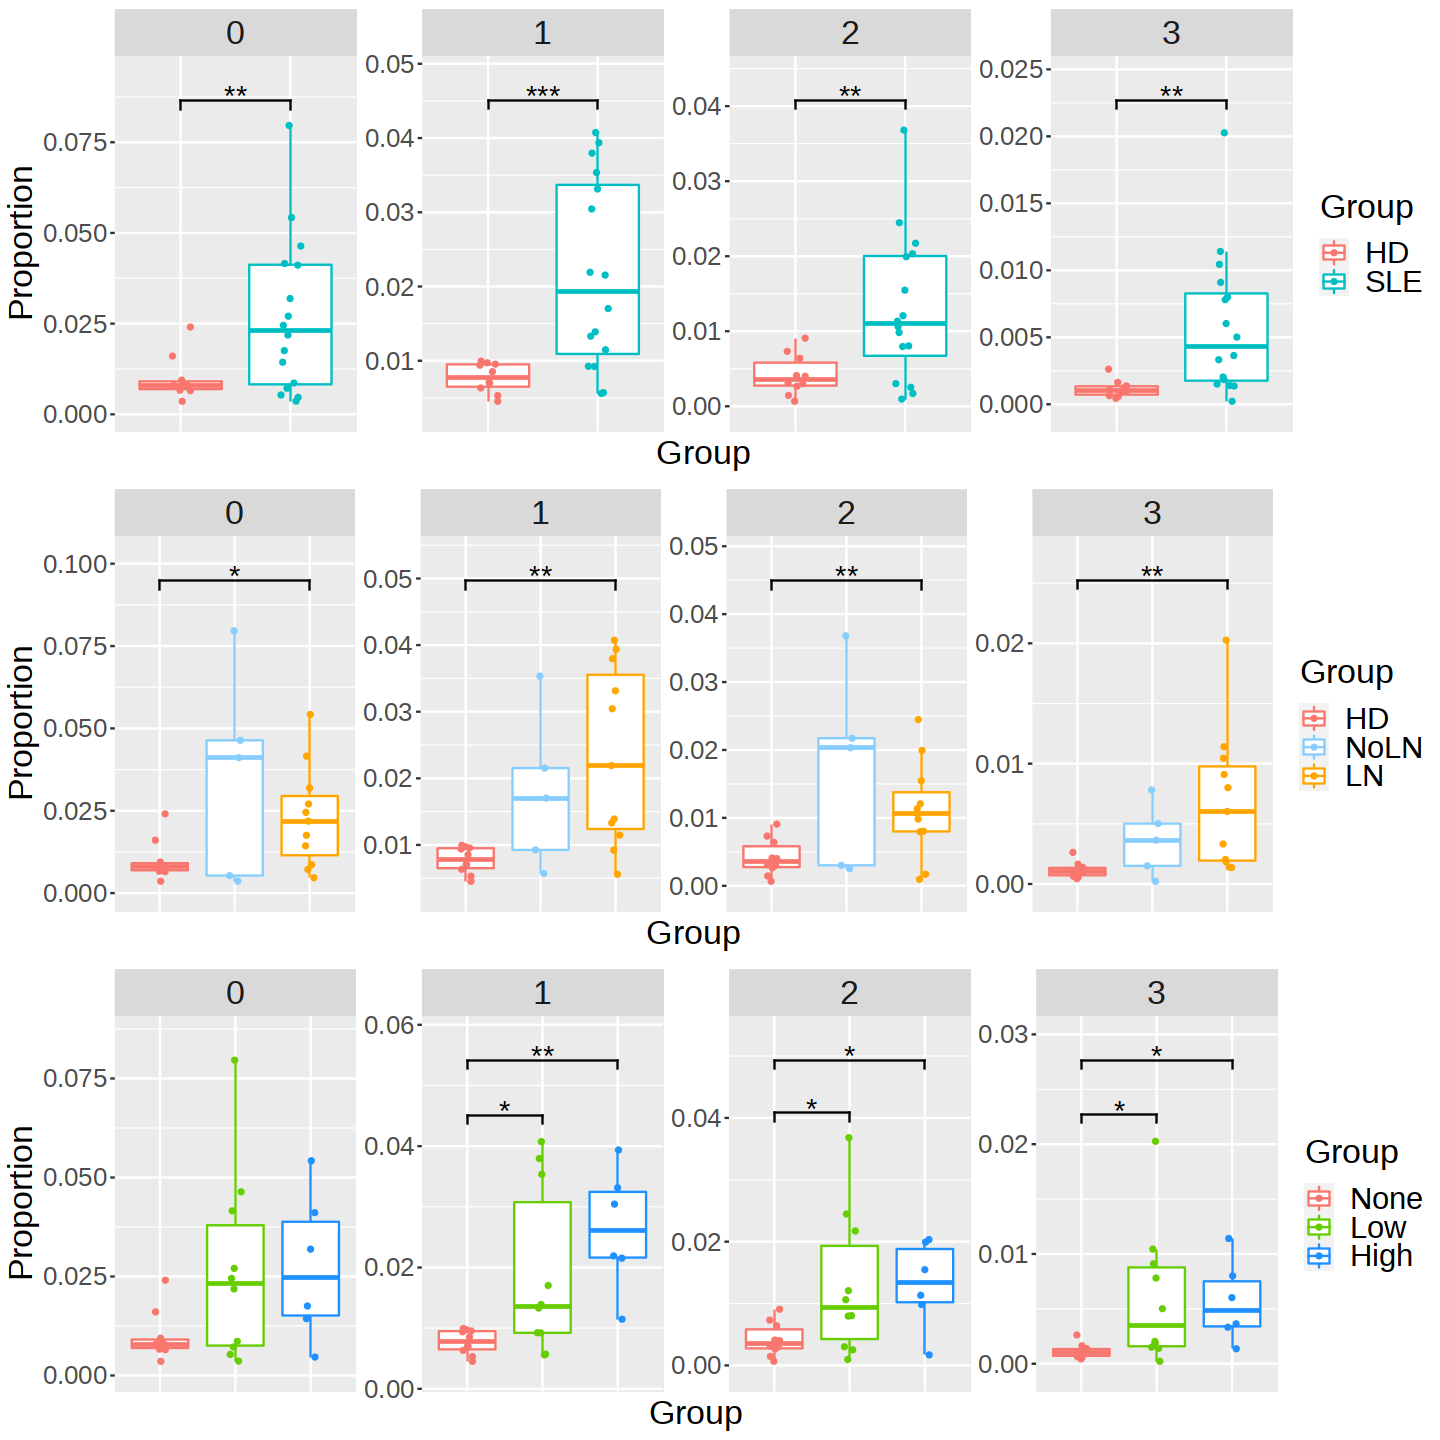

In [27]:
options(repr.plot.width = 15, repr.plot.height = 4)

out1 <- RunProportionPlot(cd4.isg.pi, ident = 'seurat_clusters',
                          group.by = "Group",
                          method = "unpooled",
                          unpool.by = "Sample_ID",
                          use.parent.as.ref = TRUE,
                          return.value = 'ggplot',
                          unpool.ncol = 4, group.colors = cols.group,
                          title.text.size = 20,
                          axis.title.size = 20,
                          axis.text.size = 15,
                          legend.title.size = 20,
                          legend.text.size = 18
)

out2 <- RunProportionPlot(cd4.isg.pi, ident = 'seurat_clusters',
                          group.by = "Group_LN",
                          method = "unpooled",
                          unpool.by = "Sample_ID",
                          use.parent.as.ref = TRUE,
                          return.value = 'ggplot',
                          unpool.ncol = 4, group.colors = cols.ln,
                          title.text.size = 20,
                          axis.title.size = 20,
                          axis.text.size = 15,
                          legend.title.size = 20,
                          legend.text.size = 18
)

out3 <- RunProportionPlot(cd4.isg.pi, ident = 'seurat_clusters',
                          group.by = "Group_SLEDAI",
                          method = "unpooled",
                          unpool.by = "Sample_ID",
                          use.parent.as.ref = TRUE,
                          return.value = 'ggplot',
                          unpool.ncol = 4, group.colors = cols.sledai,
                          title.text.size = 20,
                          axis.title.size = 20,
                          axis.text.size = 15,
                          legend.title.size = 20,
                          legend.text.size = 18
)

p1 <- plot_grid(out1, out2, out3, nrow = 3)
options(repr.plot.width = 12, repr.plot.height = 12)
p1

## Figure 4f

In [28]:
cd4.isg.pi

An object of class Pi 
6 fields in the object: seurat.obj, exp.freq, markers, ds, cell.prop, parent.meta.data.
The following fields have been processed:
	seurat.obj: A Seurat object of 26053 features and 11828 cells.
		1 assay: RNA, and 3 reductions: pca, harmony, umap
	exp.freq: A list of numeric matrices containing per gene expression frequencies
		1 analysis run: 
		  ExpFreq|seurat_clusters|cutoff=0
	markers: A list of data frames containing marker results.
		1 analysis run: 
		  Markers|seurat_clusters|AllMarkers|test.use=wilcox
	ds: A list of lists and data frames containing pseudobulk analysis results.
		1 analysis run: 
		  DS|seurat_clusters|edgeR|group=Group;sample=Sample_ID;gp1=SLE;gp2=HD;contrast=SLE-HD;block=Dataset
	parent.meta.data: A list of data frames containing parent metadata
		1 metadata: 
		  ParentMetaData|parent=cd4.harmony.clean
Metadata from the parent object provided? Yes 
Subclusters integrated? No

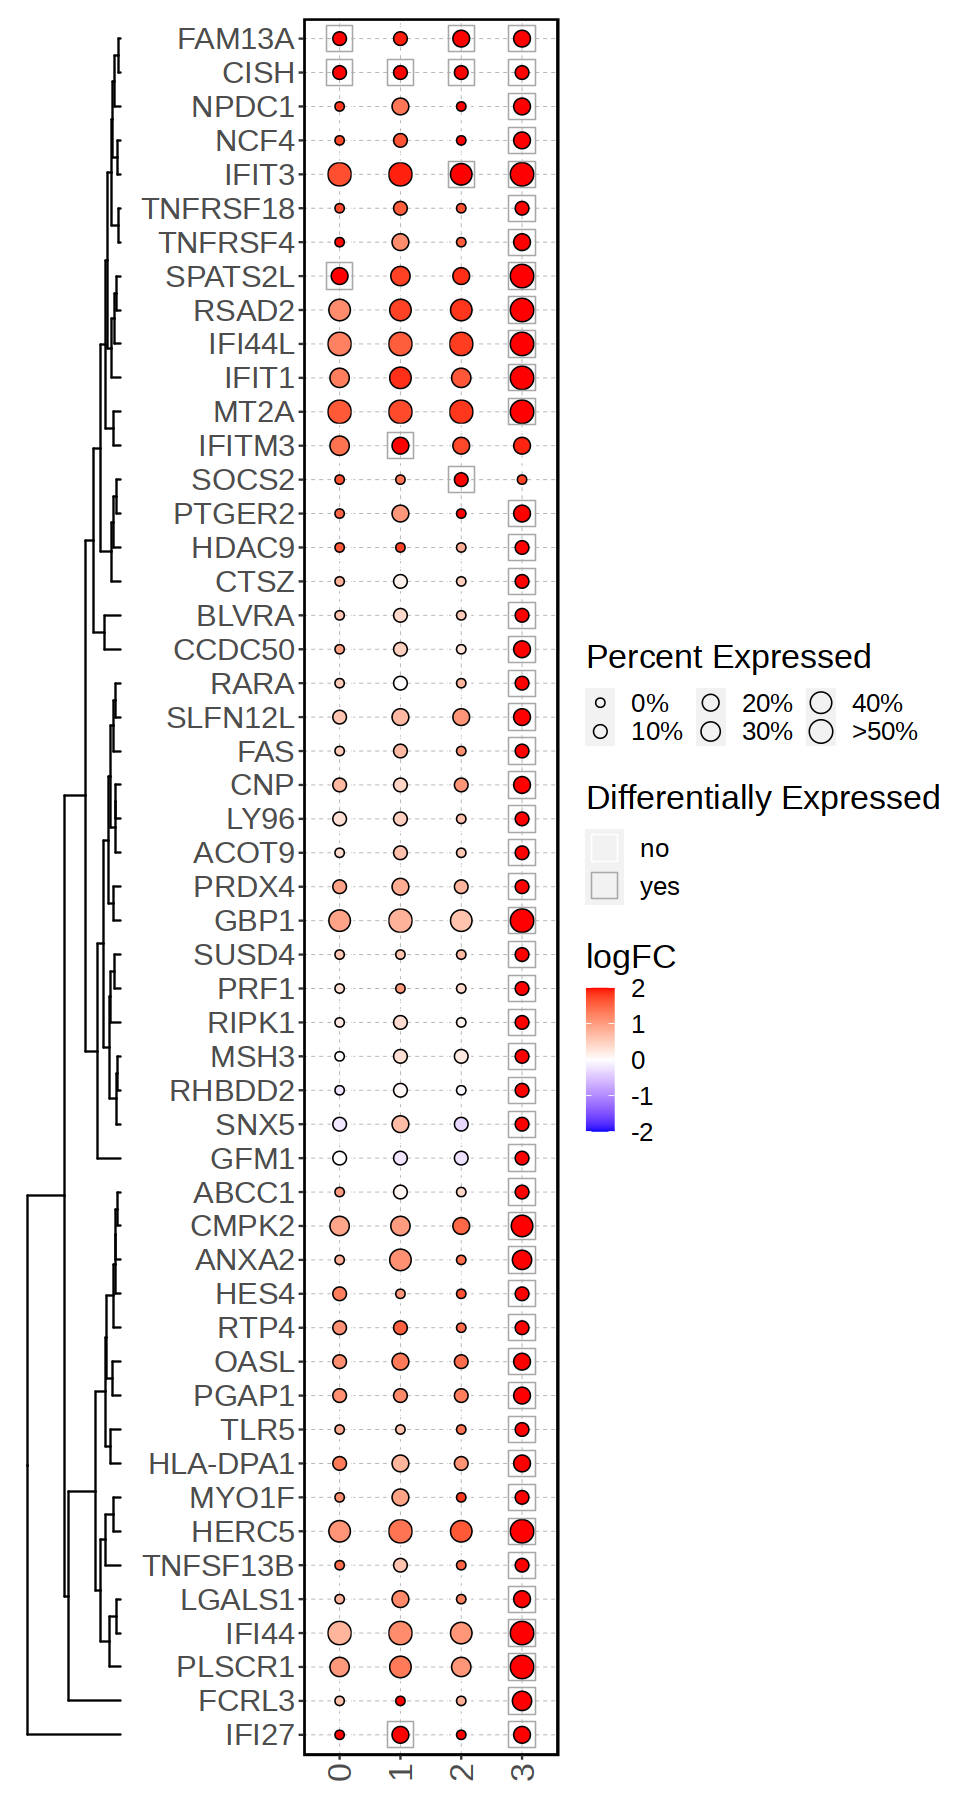

In [29]:
options(repr.plot.width = 8, repr.plot.height = 15)
p1 <- RunDSDotPlot(object = cd4.isg.pi, features = NULL,
                   exp.freq.key = "ExpFreq|seurat_clusters|cutoff=0",
                   ds.key = "DS|seurat_clusters|edgeR|group=Group;sample=Sample_ID;gp1=SLE;gp2=HD;contrast=SLE-HD;block=Dataset",
                   p.filter = 0.05,
                   FC.filter = 4,
                   to.adjust = TRUE,
                   column.fontsize = 20,
                   row.fontsize = 18,
                   column.names.rotation = 90,
                   legend.label.fontsize = 15,
                   legend.title.fontsize = 20)